### Lyrics Data

Here we want to preprocess and also train a DistilBERT model determining if a gons is a hit or not simply based on its lyrics. This mode should just be a supporting mode, and stand alone performance is expected to be pretty bad, but non the ledd we can still tune a DistilBERT model for a valid tuned embedding later on.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Load the lyrics data
spotify_lyrics = pd.read_csv('lyrics_data/lyrics_manifest_20k.csv')


# Load the train and test data
spotify_train_20k = pd.read_csv('spotify_data/spotify_train_20k.csv')
spotify_test_20k = pd.read_csv('spotify_data/spotify_test_20k.csv')

In [8]:
# Clean the spotify lyrics data
# Replace \n with space
spotify_lyrics['lyrics'] = spotify_lyrics['lyrics'].str.replace('\n', ' ')
# Replace empty lyrics with [NO_LYRICS]
spotify_lyrics['lyrics'] = spotify_lyrics['lyrics'].apply(
    lambda x: f"lyrics: {x}" if pd.notna(x) and str(x).strip() != "" else "lyrics: [NO_LYRICS]"
)

In [51]:
# Save the clean lyrics data
spotify_lyrics.to_csv('lyrics_data/lyrics_manifest_20k_clean.csv', index=False)

### Tune a DistilBERT model predicting popularity of a song - Text description

In [9]:
# Split the lyrics data into train and test sets based on given split
spotify_lyrics_train = spotify_lyrics[
    spotify_lyrics["track_id"].isin(spotify_train_20k["track_id"])
]
spotify_lyrics_train = pd.merge(spotify_lyrics_train, spotify_train_20k[["track_id", "pop"]], on="track_id", how="left")


spotify_lyrics_test = spotify_lyrics[
    spotify_lyrics["track_id"].isin(spotify_test_20k["track_id"])
]
spotify_lyrics_test = pd.merge(spotify_lyrics_test, spotify_test_20k[["track_id", "pop"]], on="track_id", how="left")

In [10]:
X_train_full = spotify_lyrics_train["lyrics"].fillna("").astype(str).tolist()
X_test = spotify_lyrics_test["lyrics"].fillna("").astype(str).tolist()

y_train_full = spotify_lyrics_train["pop"]
y_test = spotify_lyrics_test["pop"]

# Split train_full into train/val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

In [2]:
# Load the DistilBERT model and tokenizer
# Since we have lyrics in multiple languages, we use a multilingual model
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['OMP_NUM_THREADS'] = '1'

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased", 
    num_labels=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [34]:
# Tokenize the lyrics for train data
X_train_tokenized = tokenizer(X_train, truncation=True, padding=True, max_length=512, return_tensors='pt')

In [35]:
# Tokenize the lyrics for validation data
X_val_tokenized = tokenizer(X_val, truncation=True, padding=True, max_length=512, return_tensors='pt')

In [11]:
# Tokenize the lyrics for test data
X_test_tokenized = tokenizer(X_test, truncation=True, padding=True, max_length=512, return_tensors='pt')

In [12]:
# index the labels (pop) for compatibility with distilbert
label2id = {"flop": 0, "regular": 1, "hit": 2}
id2label = {v: k for k, v in label2id.items()}

# Convert the labels to index
y_train_indexed = np.array([label2id[label] for label in y_train], dtype = "int32")
y_val_indexed = np.array([label2id[label] for label in y_val], dtype = "int32")
y_test_indexed = np.array([label2id[label] for label in y_test], dtype = "int32")

Below we train the model

In [14]:
# Select the hyperparameters
batch_size = 16
epochs = 50
learning_rate = 2e-05

In [15]:
# Freeze all layers
for param in model.distilbert.parameters():
    param.requires_grad = False

# Unfreeze ONLY the last transformer layer
for param in model.distilbert.transformer.layer[-1].parameters():
    param.requires_grad = True

# Unfreeze classifier head
for param in model.classifier.parameters():
    param.requires_grad = True


In [40]:
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total params: {total:,}")
print(f"Trainable params: {trainable:,}")
print(f"Frozen params: {total - trainable:,}")


Total params: 135,326,979
Trainable params: 7,680,771
Frozen params: 127,646,208


In [16]:
# GPU availabilty check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


Using device: cuda
GPU name: NVIDIA GeForce RTX 4090 Laptop GPU


In [42]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Prepare datasets
train_dataset = TensorDataset(
    X_train_tokenized['input_ids'],
    X_train_tokenized['attention_mask'],
    torch.tensor(y_train_indexed, dtype=torch.long)
)
val_dataset = TensorDataset(
    X_val_tokenized['input_ids'],
    X_val_tokenized['attention_mask'],
    torch.tensor(y_val_indexed, dtype=torch.long)
)
test_dataset = TensorDataset(
    X_test_tokenized['input_ids'],
    X_test_tokenized['attention_mask'],
    torch.tensor(y_test_indexed, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Move model to GPU
model = model.to(device)

# Optimizer
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# Track metrics
history = {
    'train_loss': [], 'train_acc': [], 'train_auc': [],
    'val_acc': [], 'val_auc': [], 'epoch': []
}

# Early stopping
patience = 6
best_auc = 0
no_improve = 0

for epoch in range(epochs):
    # TRAIN
    model.train()
    train_loss = 0
    train_preds, train_probs, train_labels = [], [], []
    
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_probs.extend(torch.softmax(outputs.logits, dim=1).detach().cpu().numpy())
        train_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    
    train_acc = accuracy_score(train_labels, train_preds)
    train_auc = roc_auc_score(train_labels, train_probs, multi_class='ovr')
    
    # VALIDATION
    model.eval()
    val_preds, val_probs, val_labels = [], [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            val_probs.extend(torch.softmax(outputs.logits, dim=1).cpu().numpy())
            val_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_acc = accuracy_score(val_labels, val_preds)
    val_auc = roc_auc_score(val_labels, val_probs, multi_class='ovr')
    
    # Log
    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss/len(train_loader):.4f} | "
          f"Train Acc: {train_acc:.4f} AUC: {train_auc:.4f} | "
          f"Val Acc: {val_acc:.4f} AUC: {val_auc:.4f}")
    
    # Store
    history['train_loss'].append(train_loss/len(train_loader))
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    history['epoch'].append(epoch+1)
    
    # Early stopping
    if val_auc > best_auc:
        best_auc = val_auc
        no_improve = 0
        torch.save(model.state_dict(), 'best_distilbert_model_lyrics.pt')
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


Epoch 1/50 | Loss: 0.8313 | Train Acc: 0.6171 AUC: 0.7664 | Val Acc: 0.6582 AUC: 0.7950
Epoch 2/50 | Loss: 0.7873 | Train Acc: 0.6414 AUC: 0.7884 | Val Acc: 0.6603 AUC: 0.7999
Epoch 3/50 | Loss: 0.7725 | Train Acc: 0.6480 AUC: 0.7950 | Val Acc: 0.6573 AUC: 0.8011
Epoch 4/50 | Loss: 0.7592 | Train Acc: 0.6541 AUC: 0.8016 | Val Acc: 0.6624 AUC: 0.8046
Epoch 5/50 | Loss: 0.7482 | Train Acc: 0.6596 AUC: 0.8050 | Val Acc: 0.6548 AUC: 0.8023
Epoch 6/50 | Loss: 0.7320 | Train Acc: 0.6668 AUC: 0.8129 | Val Acc: 0.6539 AUC: 0.8038
Epoch 7/50 | Loss: 0.7148 | Train Acc: 0.6764 AUC: 0.8173 | Val Acc: 0.6470 AUC: 0.7970
Epoch 8/50 | Loss: 0.6957 | Train Acc: 0.6847 AUC: 0.8262 | Val Acc: 0.6509 AUC: 0.7985
Epoch 9/50 | Loss: 0.6747 | Train Acc: 0.6940 AUC: 0.8332 | Val Acc: 0.6503 AUC: 0.7960
Epoch 10/50 | Loss: 0.6493 | Train Acc: 0.7081 AUC: 0.8453 | Val Acc: 0.6533 AUC: 0.7958
Early stopping at epoch 10


In [20]:
# Load best model and evaluate on TEST
model.load_state_dict(torch.load('best_distilbert_model_lyrics.pt'))
model.eval()
test_preds, test_probs, test_labels = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        test_probs.extend(torch.softmax(outputs.logits, dim=1).cpu().numpy())
        test_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs, multi_class='ovr')
print(f"\nFinal Test Acc: {test_acc:.4f} | Test AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=["flop", "regular", "hit"]))


C:\Users\brian\AppData\Local\Temp\ipykernel_7172\1406497326.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_distilbert_model_lyric


Final Test Acc: 0.4286 | Test AUC: 0.6741

Classification Report:
              precision    recall  f1-score   support

        flop       0.39      0.79      0.53      1445
     regular       0.83      0.28      0.41      3527
         hit       0.02      0.79      0.05        28

    accuracy                           0.43      5000
   macro avg       0.42      0.62      0.33      5000
weighted avg       0.70      0.43      0.44      5000



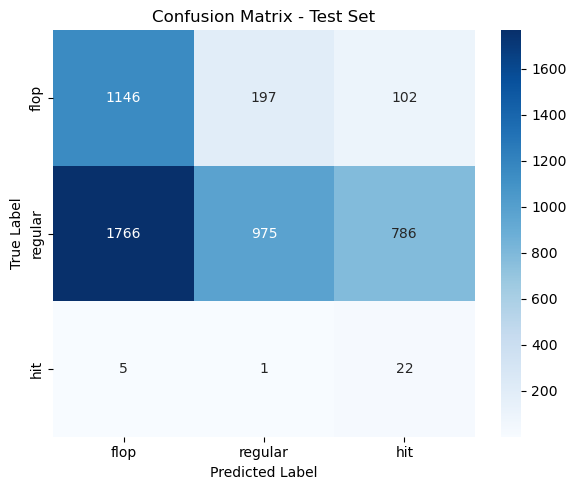

In [62]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# After computing test_labels and test_preds...

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Class names in your task
classes = ["flop", "regular", "hit"]

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


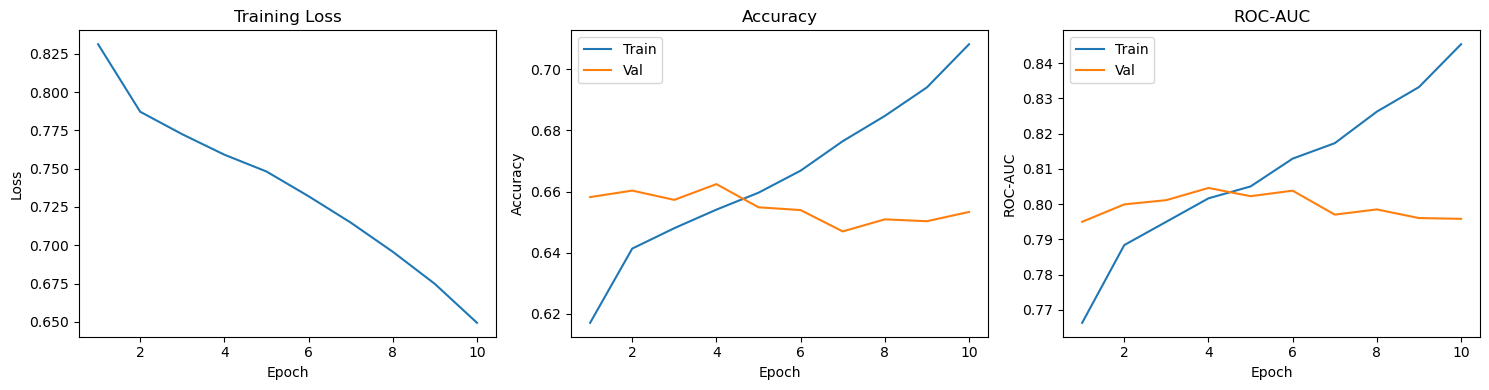

In [45]:
# Plot train/val metrics
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(history['epoch'], history['train_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 3, 2)
plt.plot(history['epoch'], history['train_acc'], label='Train')
plt.plot(history['epoch'], history['val_acc'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(history['epoch'], history['train_auc'], label='Train')
plt.plot(history['epoch'], history['val_auc'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend()
plt.title('ROC-AUC')
plt.tight_layout()
plt.show()

### Create embeddig with tuned DistilBERT

we want to extract the embedded representation (final layer of DistilBERT) as the input to be attached to the later multimodal model


In [21]:
# Extract embeddings from fine-tuned DistilBERT (after pre_classifier layer)
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Prepare data in spotify_sample_20k order
text_descriptions = spotify_lyrics["lyrics"].fillna("").astype(str).tolist()
track_ids = spotify_lyrics["track_id"].tolist()

# Tokenize all texts
tokenized = tokenizer(text_descriptions, truncation=True, padding=True, max_length=512, return_tensors='pt')

# Create DataLoader
dataset = TensorDataset(tokenized['input_ids'], tokenized['attention_mask'])
loader = DataLoader(dataset, batch_size=32)

# Extract embeddings
model.eval()
all_embeddings = []

with torch.no_grad():
    for batch in loader:
        input_ids, attention_mask = [b.to(device) for b in batch]
        
        # Forward through distilbert
        distilbert_output = model.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]  # (batch_size, seq_length, 768)
        pooled_output = hidden_state[:, 0]   # [CLS] token: (batch_size, 768)
        
        # Forward through pre_classifier
        embeddings = model.pre_classifier(pooled_output)  # (batch_size, 768)
        
        all_embeddings.append(embeddings.cpu().numpy())

# Concatenate all embeddings
embeddings_array = np.vstack(all_embeddings)

# Create DataFrame with track_id and embedding columns
embedding_cols = {f'lyrics_emb_{i+1}': embeddings_array[:, i] for i in range(768)}
lyrics_embeddings_df = pd.DataFrame({'track_id': track_ids, **embedding_cols})

# Verify order is preserved
assert (lyrics_embeddings_df['track_id'].values == spotify_lyrics['track_id'].values).all(), "Track ID order mismatch!"

print(f"Shape: {lyrics_embeddings_df.shape}")
print(lyrics_embeddings_df.head())

# Save the embeddings
lyrics_embeddings_df.to_csv('lyrics_data/lyrics_embeddings_20k.csv', index=False)

Shape: (21500, 769)
                 track_id  lyrics_emb_1  lyrics_emb_2  lyrics_emb_3  \
0  0EWF6VAofw5mnG0pUzcV3U      0.647176     -0.196885      0.399650   
1  5i6oXQ079nFUszXyRZu4uY      0.647176     -0.196885      0.399650   
2  76Nd1pesCxNehpUl4k63I4      0.533158     -0.190211      0.111517   
3  6ZthdsKjWtiCxnxbhs74vF      0.077408      0.450499     -0.415172   
4  4FcknXDJ8yW2QYUl0cm6uJ      0.436009      0.244940     -0.217472   

   lyrics_emb_4  lyrics_emb_5  lyrics_emb_6  lyrics_emb_7  lyrics_emb_8  \
0     -0.035237      0.922823     -0.097176     -0.975448      0.113674   
1     -0.035237      0.922823     -0.097176     -0.975448      0.113674   
2      0.300790      0.590799     -0.107349     -0.146171      0.036206   
3     -0.203183      0.136715      0.111498      0.642067     -0.361582   
4     -0.129692      0.247969     -0.189300      0.439263     -0.246762   

   lyrics_emb_9  ...  lyrics_emb_759  lyrics_emb_760  lyrics_emb_761  \
0      0.084962  ...       -0.

In [22]:
lyrics_embeddings_df

,track_id,lyrics_emb_1,lyrics_emb_2,lyrics_emb_3,lyrics_emb_4,lyrics_emb_5,lyrics_emb_6,lyrics_emb_7,lyrics_emb_8,lyrics_emb_9,...,lyrics_emb_759,lyrics_emb_760,lyrics_emb_761,lyrics_emb_762,lyrics_emb_763,lyrics_emb_764,lyrics_emb_765,lyrics_emb_766,lyrics_emb_767,lyrics_emb_768
0,0EWF6VAofw5mnG0pUzcV3U,0.647176,-0.196885,0.399650,-0.035237,0.922823,-0.097176,-0.975448,0.113674,0.084962,...,-0.221980,0.343505,-0.193215,-0.494038,0.108199,-0.183997,-0.482674,0.637025,0.322882,-0.393559
1,5i6oXQ079nFUszXyRZu4uY,0.647176,-0.196885,0.399650,-0.035237,0.922823,-0.097176,-0.975448,0.113674,0.084962,...,-0.221980,0.343505,-0.193215,-0.494038,0.108199,-0.183997,-0.482674,0.637025,0.322882,-0.393559
2,76Nd1pesCxNehpUl4k63I4,0.533158,-0.190211,0.111517,0.300790,0.590799,-0.107349,-0.146171,0.036206,0.263421,...,-0.266566,0.103455,-0.054047,0.241467,0.013153,-0.054965,0.034485,0.480627,0.334275,-0.088105
3,6ZthdsKjWtiCxnxbhs74vF,0.077408,0.450499,-0.415172,-0.203183,0.136715,0.111498,0.642067,-0.361582,-0.433557,...,0.359381,-0.263343,0.609558,0.254574,0.034861,-0.169303,-0.506781,0.063068,0.305487,0.512909
4,4FcknXDJ8yW2QYUl0cm6uJ,0.436009,0.244940,-0.217472,-0.129692,0.247969,-0.189300,0.439263,-0.246762,0.241729,...,0.153671,-0.074183,0.402508,-0.027873,-0.217397,-0.027823,-0.402914,0.206984,0.214304,0.266796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21495,2F9bB7O9AyzHVYQFgfRdC5,0.647176,-0.196885,0.399650,-0.035237,0.922823,-0.097176,-0.975448,0.113674,0.084962,...,-0.221980,0.343505,-0.193215,-0.494038,0.108199,-0.183997,-0.482674,0.637025,0.322882,-0.393559
21496,01SGYv7AvpUCaWS3QISqoi,0.647176,-0.196885,0.399650,-0.035237,0.922823,-0.097176,-0.975448,0.113674,0.084962,...,-0.221980,0.343505,-0.193215,-0.494038,0.108199,-0.183997,-0.482674,0.637025,0.322882,-0.393559
21497,5XwjElz3Voi6plWJQdzmiI,0.555507,-0.187393,0.070888,0.547934,0.954629,-0.004741,-0.777629,0.311408,0.268906,...,-0.408740,-0.080233,-0.412386,-0.178541,0.113983,-0.117975,0.022849,0.740273,0.180535,-0.268967
21498,5XpJHmJaDGR0mzjBrdD6WD,0.298450,0.768351,-0.383480,-0.565847,0.222186,-0.023173,0.651733,-0.015546,-0.267515,...,0.458620,0.021299,0.562785,0.381771,-0.023674,-0.148285,-0.678661,0.140486,0.292720,0.633447
